*created 19 Feb 2026, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 5303 "AI and Machine Learning in Ocean Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES5303_ML_ocean) page.

---
# 8. Generative Adversarial Networks (GANs)

GANs were introduced in [2014](https://arxiv.org/abs/1406.2661), although related ideas have made appearances here and there before that. Here we are going to introduce the idea behind GANs, apply them for generating some synthetic data based on given training data, and highlight some of the potential issues that can show up.

> ## Key Objective(s)
> 1. Introduce the concept of a generator and discrimnator network.
> 2. Demonstrate the issue of mode collapse in GANs.
> 3. Provide an example of a conditional GAN.
> 4. Quick demonstration of a convolutional GAN.

Here I am going to go back to `PyTorch` instead of doing this in `Keras`. I am sure you can do it in `Keras` properly (and I did at first), but there were some `Keras` code behaviour that I was not entirely comfortable with. With the below `PyTorch` implementation it ends up more verbose, but at least I am confident that what I tell the code to do is in fact what the code is doing (which wasn't the case for my `Keras` implementation). If you are interested, have a look at one of the extended exercises.

In [1]:
# load some packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines  # for adding proxy legend entries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

---
## a) vanilla GAN

The ***generative*** part of GAN refers to the ability that the GAN generates some desired output given some input. An example of this would be "deep fakes": provide a prompt and get the model to generate something based on that prompt.

> NOTE: ***Diffusion models*** are also generative but they work differently. We may revisit diffusion models in one of the bonus sessions.

At the basic level a GAN has two parts:

1. A ***generator*** network that turns some input noise into something (e.g. text, images, voice, music, videos etc.)
2. A ***discriminator*** network that tries to classify (see `03_classification_and_forests`) whether the "something" in the above is "true" (provided as part of the training) or "fake" (i.e. an output of the generator above)

Then you essentially make them fight each other: The generator tries to hoodwink the discriminator, but as the discriminator gets better, the generator needs to also get better, and you hope that the resulting generated data becomes increasingly "good" in whatever qualitative or quantitative sense you want it to mean.

<img src="https://i.imgur.com/1TcdSBz.png" width="600" alt='gan'>

> NOTE: Compare this to ***evolutionary arms race*** in evolution biology. There are other machine learning algorithms that mimic evolutional biology (e.g. [genetic programming](https://en.wikipedia.org/wiki/Genetic_programming), which we may or may not end up considering).

GANs effectively try to mimic the probability distribution of the data, i.e. the generator tries to generates data according to the probability distribution it ends up latching on to (cf. variational autoencoder that generates things according to the statistics you end up giving it). Since GANs are based on neural networks the universal approximation theorem holds in principle. For the training, for a loss related to classification, the generator tries to minimise the loss (by generating very good "fakes"), while the discriminator tries to maximise the loss (by being very good at telling apart "true" and "fake" data), giving rise to what is known as a ***minimax game***. In the original GAN implementation, the games are assumed to be ***zero-sum games***: equilibrium exists, and that the ordering of moves (generator plays first, discriminator plays first, or they play simultaneously) does not affect the equilibrium. 

> NOTE: The equilibriums associated with the ordering above would be the minmax, the maxmin, and the ***Nash equilibrium***. For the last one, see for example the film "[A Beautiful Mind](https://en.wikipedia.org/wiki/A_Beautiful_Mind_(film))" about the Nobel prize winner [John Nash](https://en.wikipedia.org/wiki/John_Forbes_Nash_Jr.).

In general of course none of the above strictly holds, but we nevertheless use it as a guiding principle and proceed accordingly. 

### Test case: vanilla GAN to generate synthetic `penguins` data

The aim here is to generate synthetic data via training a GAN on the given `penguins` data. The test use below is based on an example given [here](https://medium.com/the-research-nest/exploring-gans-to-generate-synthetic-data-ca48f8a4b518), although I redid things in `PyTorch`. Going to load and use all the data, standarise them, and convert them to `FloatTensors` as usual. For now I do not use the `species` attribute at all.

In [2]:
# load the penguin data
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# turn these into PyTorch tensors
X_train = torch.FloatTensor(X_scaled)

print(f"X_train tensor size after = {X_train.size()}")
print(" ")

loading data remotely
X_train tensor size after = torch.Size([342, 4])
 


In the below I am going to define a `Generator` and `Discriminator` class, and these are just simple MLPs with the `nn.Linear` layers in `PyTorch` (these would be `layers.Dense` in `Keras`).

* The generator is going to take in some noise (100 samples of these) and spit out four numbers (the four features in `penguins.csv`).
* The discriminator is going to take in four numbers (the four features in `penguins.csv`) and spit out a *single* number between 0 and 1 (enabled via the `nn.Sigmoid` activation function, which maps everything down to [0, 1]). Usually 0 would be "fakes" and 1 would be "real", although that doesn't strictly matter as long as we are consistent about it.

> NOTE: The `.squeeze()` is to remove any singleton dimensions that may arise. I could have defined things so we don't need it here, but we will need it later when we have some singleton channel dimensions for images, so I modified things accordingly so we do need it.

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, feature_dim=4):
        super().__init__()
        self.layer_size = 128
        self.model = nn.Sequential(
            nn.Linear(noise_dim, self.layer_size),
            nn.ReLU(),
            nn.Linear(self.layer_size, feature_dim)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, feature_dim=4):
        super().__init__()
        self.layer_size = 128
        self.model = nn.Sequential(
            nn.Linear(feature_dim, self.layer_size),
            nn.ReLU(),
            nn.Linear(self.layer_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).squeeze()

I am going to initialise the model and set the random seeds. For the loss we are going to use ***binary cross entropy*** (`nn.BCEloss()`). For the optimizers the default `Adam` is used.

> NOTE: I set both `torch` and `np` seeds because I will be calling randomiser functions with both below (`torch.randn` and `np.shuffle` respectively).

In [4]:
# instantiate model
torch.manual_seed(4321)
np.random.seed(4321)

noise_dim, feature_dim = 100, 4

generator = Generator(noise_dim=noise_dim, feature_dim=feature_dim)
discriminator = Discriminator(feature_dim=feature_dim)

# define things that are used for training
J = nn.BCELoss()
# J = nn.BCEWithLogitsLoss()
learning_rate = 0.001
generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

The whole thing below is the GAN and I do the batching and training manually. The cell is quite long, and I am going to summarise the GAN part first:

1. The *discriminator* moves first:
   - Create some noise, pass it to the generator, label the outputs as "fake" (by providing them with `0` labels), compute loss, and then update the *discriminator*.
   - Pass the "real" data (labelled as `1`), compute loss, and then update the *discriminator* again.
2. The *generator* moves second:
   - Create some noise again, pass it to the generator.
   - Get the discriminator to do its thing with those outputs.
   - Compute loss with the input that the generator generated "real" data (i.e. label the outputs as `1`), then update *generator*.

Repeat as necessary. 

> <span style="color:red">Q.</span> You might be a bit bothered like I was initially that there are **separate** discriminator updates for the "fake" and "real" data. Apparently this is a thing that is done to help with GAN training via a ***curriculum training*** of sorts, since GANs are somewhat notorious for being difficult to train for more complex datasets. You could try commenting and uncommenting some lines below where a calculation of a backward based on `J_dis = J_true + J_fake` is done instead.

An important point here is that the generator is kept *fixed* when the discriminator is updated in step 1, while the discriminator is kept *fixed* when the generator is updated in step 2. The slightly tricky practical part that one needs to be careful about is to only compute gradients and update the right components at the appropriate locations. This is reasonably easy to do in `PyTorch`, because I can explicitly call `J_fake/real.backwards()` followed by `discriminator_optimizer.step()` for step 1, and `J_gen.backwards()` followed by `generator_optimizer.step()` for step 2 in appropriate orders. 

> NOTE: If you do this in `Keras` the default `.fit()` and/or `.train_on_batch()` doesn't quite work in that those commands tape everything, does the back-propagation and updates at the same time. A bit more fine tuning is needed.

The manual batching is done by grabbing the training data sample size, generate a full set of indicies and get the (integer) number of batches that depends on `batch_size`. At every epoch I shuffle the indices and grab the appropriate indices (based on `batch_size`) and train per batch, with a bit of care needed for that last batch that is smaller than `batch_size`.

> <span style="color:red">Q.</span> I did manual batching because I sort of needed it in `Keras`. You probably could have done this with `Dataset` and `Dataloader` objects here actually; give that a go if you want.
>
> <span style="color:red">Q.</span> There is an issue that the last stray batch might be significantly smaller than the specified `batch_size`, which I did not bother trying to avoid. You could try putting in an extra clause to say that if the stray batch has size smaller than some percentage (say 50%) then have a bigger batch instead, suggest a different `batch_size`, or some other variations thereof.

In [5]:
# some intermediate variables for the manual batching
batch_size = 128
num_epochs = 5000
out_epoch = num_epochs // 10

J_discriminator = np.zeros(num_epochs)
J_generator = np.zeros(num_epochs)

# some intermediate variables for the manual batching
num_samples = X_scaled.shape[0]
inds = np.arange(num_samples)
# number of batches = batch_size, then +1 for leftover
num_batches = num_samples // batch_size + 1

# this whole loop is the GAN
for epoch in range(num_epochs):

    # reset the running loss each epoch
    running_J_discriminator = 0.0
    running_J_generator = 0.0

    # shuffle batch indices then loop over batches
    np.random.shuffle(inds)

    for i in range(num_batches):
        if i < num_batches:
            idx = inds[i*batch_size:(i+1)*batch_size]
        else:
            idx = inds[(num_batches-1):]
        
        X_batch = X_train[idx]
        dummy_batch_size = X_batch.shape[0]
    
        ##### 1) discriminator #####
        discriminator_optimizer.zero_grad()
        
        # generate fake data and train discriminator
        # fake data (labelled by 0s) then on real data (labelled by 1s)
        fake_data = generator(torch.randn(dummy_batch_size, noise_dim))
        fake_preds = discriminator(fake_data)
        J_fake = J(fake_preds, torch.zeros(dummy_batch_size))  # 0s here
        J_fake.backward()
        discriminator_optimizer.step()
    
        # Train the discriminator on the real data
        real_data = X_batch
        real_preds = discriminator(real_data)
        J_real = J(real_preds, torch.ones(dummy_batch_size))  # 1s here
        J_real.backward()
        discriminator_optimizer.step()

        # alternative: accumulate cost then backwards rather than separately as above
        # J_dis = J_real + J_fake
        # J_dis.backward()
        # discriminator_optimizer.step()

        running_J_discriminator += (J_real.item() + J_fake.item()) * dummy_batch_size
    
        ##### 2) generator (but keeping the discriminator FIXED!) #####
        generator_optimizer.zero_grad()
        
        fake_data = generator(torch.randn(dummy_batch_size, noise_dim))
        preds = discriminator(fake_data)
        J_gen = J(preds, torch.ones(dummy_batch_size))  # regard data as all "real"
        J_gen.backward()
        generator_optimizer.step()

        running_J_generator += J_gen.item() * dummy_batch_size

    J_discriminator[epoch] = running_J_discriminator / num_samples
    J_generator[epoch] = running_J_generator / num_samples

    if (epoch == 0) or ((epoch+1) % out_epoch == 0):
        print(f" epoch: {epoch+1} / {num_epochs}, "
            + f"discriminator loss: {J_discriminator[epoch]:.6f}, "
            + f"generator loss: {J_generator[epoch]:.6f}")
        

 epoch: 1 / 5000, discriminator loss: 1.312042, generator loss: 0.574700
 epoch: 500 / 5000, discriminator loss: 1.293523, generator loss: 1.294866
 epoch: 1000 / 5000, discriminator loss: 1.318044, generator loss: 1.701682
 epoch: 1500 / 5000, discriminator loss: 1.255394, generator loss: 1.365558
 epoch: 2000 / 5000, discriminator loss: 1.222908, generator loss: 1.525186
 epoch: 2500 / 5000, discriminator loss: 1.191252, generator loss: 1.360247
 epoch: 3000 / 5000, discriminator loss: 1.088273, generator loss: 1.377737
 epoch: 3500 / 5000, discriminator loss: 1.108189, generator loss: 1.379536
 epoch: 4000 / 5000, discriminator loss: 1.191137, generator loss: 1.629645
 epoch: 4500 / 5000, discriminator loss: 1.177989, generator loss: 1.449105
 epoch: 5000 / 5000, discriminator loss: 1.171687, generator loss: 1.555727


We plot out the loss as usual. First thing to notice is the loss values are not that small: for normalised data we might want them to be smaller than 1, but these are hovering around 1. This is not an issue as such, because the real test is actually in the data that is being outputted by the generator that we will examine later.

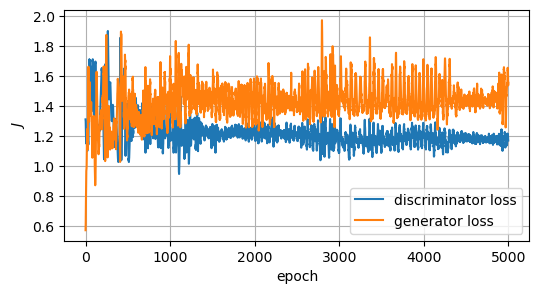

In [6]:
# plot out the losses
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(J_discriminator, label="discriminator loss")
ax.plot(J_generator, label="generator loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

The zero-sum nature of the game is such that one's gain is the other's loss, so one possibility that could happen (and is why I have some doubts about my `Keras` implementation of GAN) is that the generator gets better not because it is actually doing a better job, but simply because the discriminator is not being trained/updated properly and is bad at its job, so the generator does not need to work as hard. This could happen if I am not updating the gradients properly (e.g. if I made a mistake and updated both discriminator and generator at step 2, when I was only supposed to update the generator).

As you can see the loss for both the discriminator and generator is fluctuating quite a bit, which highlights the inherent competition that is occuring between the two. This competition can cause problems numerically (e.g. model convergence) because of the tug-of-war between the two opposing models. 

> NOTE: We come back to this point next time when dealing with ***PINNs***, where an analogous issue occurs but this time through the penalisation term in the loss function.

Below we can see how the synthetic data looks by calling the generator and plot it alongside the real data to see whether it is believable or not. I am going to do the easy thing and just do a 2d scatter plot by manually selecting two feature dimensions to plot against each other.

> NOTE: I chose `body_mass_g` and `bill_depth_mm` to mirror what I have been using in the previous lectures.

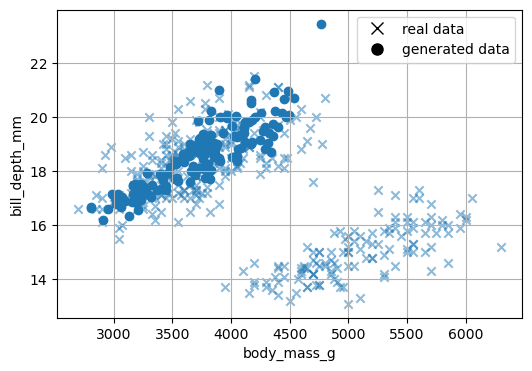

In [7]:
# generate some synethetic data and compare against real data
def generate_data(generator, num_sample, noise_dim=100):
    with torch.no_grad():
        data_gen = generator(torch.randn((num_sample, noise_dim)))
    return data_gen.numpy()

# (body_mass_g, bill_depth_mm) to mirror diagram in lec01 (and elsewhere)
features_inds = [3, 1]

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
    
# undo the scalings
X = scaler.inverse_transform(X_scaled)
X_gen = scaler.inverse_transform(generate_data(generator, 150, noise_dim=noise_dim))

    # plot the dimensional data
ax.scatter(X[:, features_inds[0]], X[:, features_inds[1]],
           color=f"C0", marker="x", alpha=0.5)
ax.scatter(X_gen[:, features_inds[0]], X_gen[:, features_inds[1]], 
           color=f"C0", marker="o")

ax.set_xlabel(f"{features[features_inds[0]]}")
ax.set_ylabel(f"{features[features_inds[1]]}")

dummy_1 = mlines.Line2D([], [], color="k", linestyle="", marker="x", 
                        markersize=8, label="real data")
dummy_2 = mlines.Line2D([], [], color="k", linestyle="", marker="o", 
                        markersize=8, label="generated data")
ax.legend(handles=[dummy_1, dummy_2])
ax.grid()

Here we can see that there is an issue where the generator only seems to generate data in one block and not the other (look back in the previous lecture slides and you will find the generator is not generating data for the `Gentoo`s). This is a phenomenon called ***mode collapse***: the model "latches" too early to certain collection of data and becomes increasingly specialised for that collection, failing in turn to generate the diversity of data that is exposed to the model. Related scenarios could be:

* for generative handwritten digits the model only ever generates zeroes,
* for generating music the model only every gives you things in C major,
* for generating videos then model only ever generates white male actors,

and so forth. One way to avoid this is for example by changing the loss function to use the ***Wasserstein distance*** (resulting in the [WGAN](https://en.wikipedia.org/wiki/Wasserstein_GAN)), which you can think of as the "work" you need to do to move one pdf to another (or if a pdf is a point in some space, then it is the distance between two points in that space). This we are not going to look into because `PyTorch` at the time of writing does not have a way to compute the Wasserstein distance (although it can be hard coded, and some people have done this). There are other approaches (e.g. mini-batch discrimination, unrolling), but we are going to skip these here, because there is a slightly easier thing that sidesteps the problem a bit.

> <span style="color:red">Q.</span> I find you don't get mode collapse all the time. See if you can find a case where it doesn't collapse by changing the choice of random seed.
>
> <span style="color:red">Q.</span> The comparison I did on whether the model is generating believable data above is crude at best. See if you can be more quantitative about it. There are several things that you could try:
> 1. Compare the probability distributions of the generated data, one feature dimension at a time say.
> 2. Plot a whole load of scatter plots over pairs of feature dimensions to see how in (or out) of sample the synthetic data is.
> 3. Train up some dimension reduction model (e.g. $t$-SNE, PCA, autoencoder) on the real data and pass the fake data to that trained up model, to see how "close" (in whatever descriptive of quantitative way you want) they are in the associated latent space.
> 4. Be more quantitative and compute the Wasserstein distances between the pdfs (which you can do in `scipy` for 1d distributions; see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html)).
> 5. Some testing based on known principles of the data.
>
> <span style="color:red">Q.</span> I didn't do train-test(-validation) split, you could try that and see if that makes a difference. I did standard scaling, but you could try different things (e.g. MinMax, or don't even scale it; I would imagine the second case to be pretty bad given GANs try to match the distribution of the data).
>
> <span style="color:red">Q.</span> Where I define the loss I commented the possibility of `BCEWithLogitsLoss()`. Have a look at what that is and see what difference it makes if any.

## b) Conditional GAN (cGAN)

One way we can side-step the mode collapse observed above is to provide the label (i.e. `species` information) to the GAN. Note this does not avoid the mode collapse issue: the generated data may still have limited diversity in the associated labels. We are doing this because we already have access to the labels (or, of course, you could have generated it through from clustering, possibly with some manifold transformation like we considered in `02_more_sklearn`).

Use of binary cross entropy like what we have done with the vanilla GAN before usually requires the labels to be in the ***one-hot encoded*** form. If you used `LabelEncoder` you would get something like
\begin{equation*}
    (\mathrm{Adelie}, \mathrm{Chinstrap}, \mathrm{Gentoo}) \to (0, 1, 2).
\end{equation*}
With one-hot encoding you get something like
\begin{equation*}
    (\mathrm{Adelie}, \mathrm{Chinstrap}, \mathrm{Gentoo}) \to ([1, 0, 0], [0, 1, 0], [0, 0, 1]).
\end{equation*}
These labels are then merged (or *concatenated*) into the data that are being passed on accordingly, in effect bulking out the dimension of the input. The below turns the `species` attribute values into one-hot form using `sklearn`, which I then convert to `PyTorch` tensors for concatenating later.

In [8]:
# turn into arrays instead of single numerical value for use with chosen metric
label_encoder = OneHotEncoder(sparse_output=False)
labels = label_encoder.fit_transform(df["species"].values.reshape(-1, 1))
labels = torch.LongTensor(labels)
labels

tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]])

The generator and discriminator is basically the same, except that I define an extra variable `num_class` to specify how many extra dimensions we are adding (based on the one-hot form), and I do some concatenation here with `torch.cat` (second dimension here with `dim=1` since my data is in the form `(num_samples, features)`).

In [9]:
class cGenerator(nn.Module):
    def __init__(self, noise_dim=100, feature_dim=4, num_class=3):
        super().__init__()
        self.layer_size = 128
        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_class, self.layer_size),
            nn.ReLU(),
            nn.Linear(self.layer_size, feature_dim)
        )

    def forward(self, x, labels):
        x = torch.cat([x, labels], dim=1)
        out = self.model(x)
        return out.view(x.size(0), feature_dim)

class cDiscriminator(nn.Module):
    def __init__(self, feature_dim=4, num_class=3):
        super().__init__()
        self.layer_size = 128
        self.model = nn.Sequential(
            nn.Linear(feature_dim + num_class, self.layer_size),
            nn.ReLU(),
            nn.Linear(self.layer_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = torch.cat([x, labels], dim=1)
        out = self.model(x)
        return out.squeeze()

The settings are exactly the same as before, and the training cell below is effectively the same as before except I need to generate some fake labels in the one-hot form. This I do via `torch.randint(num_class, (dummy_batch_size,))`, which generates random integers upto the number of classes I have, and in a specific shape depending on my batch size, then I hit it with the `F.one_hot(...)` command from `PyTorch`.

In [10]:
# instantiate model
torch.manual_seed(4321)
np.random.seed(4321)

noise_dim, feature_dim = 100, 4
num_class = 3

generator = cGenerator(noise_dim=noise_dim, feature_dim=feature_dim, num_class=num_class)
discriminator = cDiscriminator(feature_dim=feature_dim, num_class=num_class)

# define things that are used for training
J = nn.BCELoss()
# J = nn.BCEWithLogitsLoss()
learning_rate = 0.001
generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [11]:
# some intermediate variables for the manual batching
batch_size = 128
num_epochs = 5000
out_epoch = num_epochs // 10

J_discriminator = np.zeros(num_epochs)
J_generator = np.zeros(num_epochs)

# some intermediate variables for the manual batching
num_samples = X_scaled.shape[0]
inds = np.arange(num_samples)
# number of batches = batch_size, then +1 for leftover
num_batches = num_samples // batch_size + 1

# this whole loop is the GAN
for epoch in range(num_epochs):

    # reset the running loss each epoch
    running_J_discriminator = 0.0
    running_J_generator = 0.0

    # shuffle batch indices then loop over batches
    np.random.shuffle(inds)

    for i in range(num_batches):
        if i < num_batches:
            idx = inds[i*batch_size:(i+1)*batch_size]
        else:
            idx = inds[(num_batches-1):]
        
        X_batch = X_train[idx]
        Y_batch = labels[idx]
        dummy_batch_size = X_batch.shape[0]
    
        ##### 1) discriminator #####
        discriminator_optimizer.zero_grad()
        
        # generate fake data and train discriminator
        # fake data (labelled by 0s) then on real data (labelled by 1s)
        fake_labels = F.one_hot(torch.randint(num_class, (dummy_batch_size,)))
        fake_data = generator(torch.randn(dummy_batch_size, noise_dim), fake_labels)
        fake_preds = discriminator(fake_data, fake_labels)
        J_fake = J(fake_preds, torch.zeros(dummy_batch_size))
        J_fake.backward()
        discriminator_optimizer.step()
    
        # Train the discriminator on the real data
        real_data = X_batch
        real_labels = Y_batch
        real_preds = discriminator(real_data, real_labels)
        J_real = J(real_preds, torch.ones(dummy_batch_size))
        J_real.backward()
        discriminator_optimizer.step()

        # alternative: accumulate cost then backwards rather than separately as above
        # J_dis = J_real + J_fake
        # J_dis.backward()
        # discriminator_optimizer.step()

        running_J_discriminator += (J_real.item() + J_fake.item()) * dummy_batch_size
    
        ##### 2) generator (but keeping the discriminator FIXED!) #####
        generator_optimizer.zero_grad()
        
        fake_labels = F.one_hot(torch.randint(num_class, (dummy_batch_size,)))
        fake_data = generator(torch.randn(dummy_batch_size, noise_dim), fake_labels)
        preds = discriminator(fake_data, fake_labels)
        J_gen = J(preds, torch.ones(dummy_batch_size))  # regard data as all "real"
        J_gen.backward()
        generator_optimizer.step()

        running_J_generator += J_gen.item() * dummy_batch_size

    J_discriminator[epoch] = running_J_discriminator / num_samples
    J_generator[epoch] = running_J_generator / num_samples

    if (epoch == 0) or ((epoch+1) % out_epoch == 0):
        print(f" epoch: {epoch+1} / {num_epochs}, "
            + f"discriminator loss: {J_discriminator[epoch]:.6f}, "
            + f"generator loss: {J_generator[epoch]:.6f}")
        

 epoch: 1 / 5000, discriminator loss: 1.414056, generator loss: 0.710482
 epoch: 500 / 5000, discriminator loss: 1.497566, generator loss: 1.291587
 epoch: 1000 / 5000, discriminator loss: 1.382891, generator loss: 1.294440
 epoch: 1500 / 5000, discriminator loss: 1.467350, generator loss: 1.219625
 epoch: 2000 / 5000, discriminator loss: 1.461282, generator loss: 1.200621
 epoch: 2500 / 5000, discriminator loss: 1.485226, generator loss: 1.146023
 epoch: 3000 / 5000, discriminator loss: 1.548380, generator loss: 1.165787
 epoch: 3500 / 5000, discriminator loss: 1.522344, generator loss: 1.301840
 epoch: 4000 / 5000, discriminator loss: 1.466182, generator loss: 1.191513
 epoch: 4500 / 5000, discriminator loss: 1.464019, generator loss: 1.091953
 epoch: 5000 / 5000, discriminator loss: 1.441268, generator loss: 1.121710


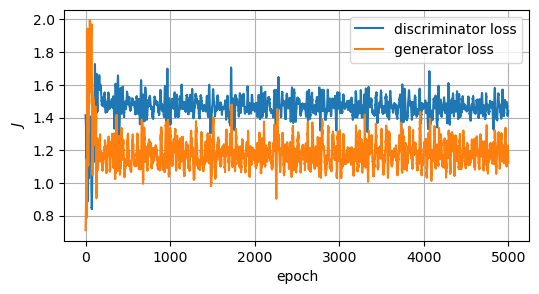

In [12]:
# plot out the losses
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(J_discriminator, label="discriminator loss")
ax.plot(J_generator, label="generator loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

Below I modify the data generation subroutine slightly, where the subroutine takes in a *string* given by `df["species"]`, put this in an array and repeat the entry `num_sample` amount of times, and that whole array is then turned into one-hot form, converted into tensors and passed to the `generator`. The predictions are coloured accordingly.

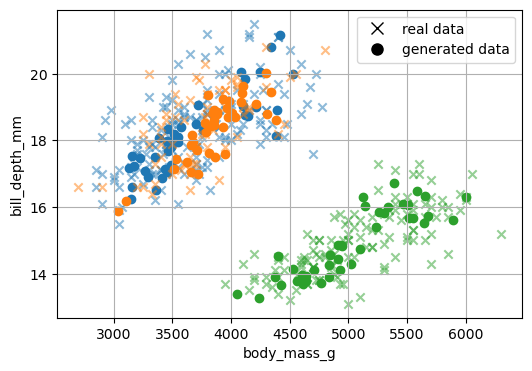

In [13]:
# generate some synethetic data and compare against real data
def generate_data_2(generator, data_class, num_sample, noise_dim=100):
    noise = torch.randn((num_sample, noise_dim))
    label = label_encoder.transform(np.array([[species]*num_sample]).reshape(-1, 1))
    label = torch.LongTensor(label)
    with torch.no_grad():
        data_gen = generator(noise, label)
    return data_gen.numpy()

# (body_mass_g, bill_depth_mm) to mirror diagram in lec01 (and elsewhere)
features_inds = [3, 1]
    
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()

for i, species in enumerate(["Adelie", "Chinstrap", "Gentoo"]):
    
    # undo the scalings
    X = scaler.inverse_transform(X_scaled[df["species"] == species])
    X_gen = scaler.inverse_transform(generate_data_2(generator, 
                                                     species, 
                                                     40, 
                                                     noise_dim=noise_dim)
                                    )

    # plot the dimensional data
    ax.scatter(X[:, features_inds[0]],
               X[:, features_inds[1]],
               color=f"C{i}", marker="x",
               alpha=0.5)
    ax.scatter(X_gen[:, features_inds[0]], X_gen[:, features_inds[1]], 
               color=f"C{i}", marker="o")

ax.set_xlabel(f"{features[features_inds[0]]}")
ax.set_ylabel(f"{features[features_inds[1]]}")

import matplotlib.lines as mlines
dummy_1 = mlines.Line2D([], [], color="k", linestyle="", marker="x", 
                        markersize=8, label="real data")
dummy_2 = mlines.Line2D([], [], color="k", linestyle="", marker="o", 
                        markersize=8, label="generated data")
ax.legend(handles=[dummy_1, dummy_2])
ax.grid()

So in this case we see that the synthetic data is at least within the appropriate clusters, so that's good at least. Note of course the above is only showing consistency for one pair of dimensions, and there is no evidence that the synthetic data is consistent in all the features dimensions, i.e. do not do what my PhD colleagues used to call "proof by example" (because an example does not constitute a "proof").

Should note again that the cGAN is just side-stepping the issue of mode-collapse rather than solving it. You can probably see visually in the above the distribution is likely quite narrow within the cluster, which is suggestive that the generator is "playing it safe" and generating samples that are not as diverse compared to that displayed in the "real" data.

> <span style="color:red">Q.</span> Be more quantitative about the demonstrating consistency of data. See above exercise for vanilla GAN for things you could/should do.
>
> <span style="color:red">Q.</span> One thing you could try is to train a classifer (of whatever variety you like) based on the synthetic data. It should do ok on the synthetic data itself, but the harder test is applying it to the real data. The degradation in skill if any would be consistent with the fact that the trained generators above are not that diverse (convince yourself why that is the case).

## c) Deep Convolutional GAN (DCGAN)

Like autoencoders and RNNs the GANs can be non-specific in their neural network architecture in the generator/discriminator, so we could also include convolution layers (cf. convolution autoencoders and ConvLSTMs). Use of convolution layers might be particularly suitable when we have image data that has some sort of spatio-temporal correlation.

In the below example I am going to do a DCGAN (although the "deep" is dubious because I am going to keep it shallow for speed reasons). For this one we are going to use the Mercator satellite data that I introduced in `05_CNNs` in one of the extended exercises. I am only going to use `mercator_cyclonic_eddy_SST` for demonstration purposes.

loading data remotely
data has already been scaled to [0, 1]
  read data shape is (pixels, num_sample) = (1225, 1506)
  reshaped to (num_sample, channel, width, height) = (1506, 1, 35, 35)


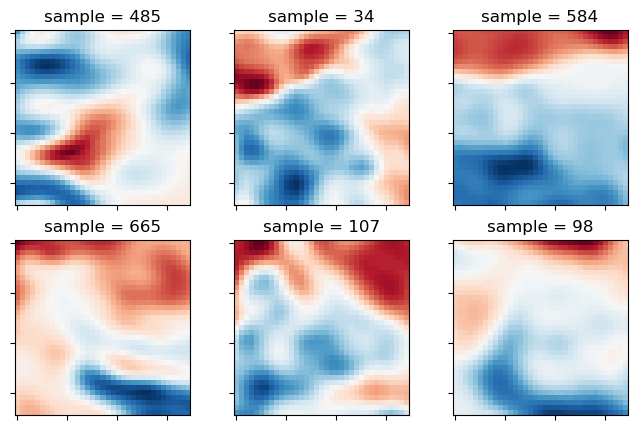

In [14]:
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "mercator_cyclonic_eddy_SST.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/mercator_cyclonic_eddy_SST.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path, header=None)

print(f"data has already been scaled to [0, 1]")
X = df.values
print(f"  read data shape is (pixels, num_sample) = {X.shape}")

# reshape into something that PyTorch wants to see: (num_sample, channel, width, height)
X = X.T.reshape(-1, 1, 35, 35)
print(f"  reshaped to (num_sample, channel, width, height) = {X.shape}")

kt_vals = np.arange(X.shape[0])
np.random.shuffle(kt_vals)

fig = plt.figure(figsize=(8, 5))
for i, kt in enumerate(kt_vals[:6]):
    ax = plt.subplot(2, 3, i+1)
    cs = ax.imshow(X[kt, 0, :, :], cmap="RdBu_r", vmin=0, vmax=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(f"sample = {kt}")

For the below example I took the structure based on a `PyTorch` tutorial from [here](https://docs.pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html), but I got rid of a few layers and fudged some parameters to make it work for this particular dataset.

> NOTE: How I went about it was I actually start with the discriminator first, which is trying to take an image (of shape `(num_sample, num_channel=1, 35, 35)`) and squash it down to a number using the `Conv2d` layers; funny choices may need to be made (e.g. my choices of `stride` and `padding` are dubious, partly because my image sizes in hindsight are dubious). Once I cook up a discriminator, I essentially reverse the ordering of those for the generator and use `ConvTranspose2d` layers instead, which is trying to take some noise (of dimension `(num_sample, noise_dim, 1, 1)`) and blow it back up to an image (of size `(num_sample, num_channel=1, 35, 35)`).
>
> The [calculator](https://madebyollin.github.io/convnet-calculator/) here might be helpful for establishing the discriminator, which then helps with the generator. The one Jonathan made for `05_CNNs` can also be used, or you could do it by hand if you want.
>
> In principle you don't have to have the discriminator and generator mirror each other, as long as the outputs are consistent. That may require a bit more experimentation for the generator though.

> <span style="color:red">Q.</span> I cooked those numbers up by brute force experimentation actually via examining the outputs sizes as it passes through the layer. Have a think and/or experiment how you might do that.

One thing I do do below is ***batch normalisation*** (via `BatchNorm2d`), which stabilises and/or improves the training somewhat. Look up what that means if you like.

In [15]:
class convDiscriminator(nn.Module):
    def __init__(self, feature_dim=32):
        super().__init__()
        self.model = nn.Sequential(
            #   (in_channels, out_channels, kernel_size, stride=1, padding=0)
            # === conv 1 === (1, 35, 35) -> (feature_dim, 13, 13)
            nn.Conv2d(1, feature_dim, 5, 
                      stride=3, padding=3, bias=False),
            # nn.BatchNorm2d(feature_dim),  # have this on?
            nn.LeakyReLU(0.2),
            # === conv 2 === (feature_dim, 13, 13) -> (feature_dim*4, 5, 5)
            nn.Conv2d(feature_dim, feature_dim*4, 5, 
                      stride=3, padding=2, bias=False),
            nn.BatchNorm2d(feature_dim*4),
            nn.LeakyReLU(0.2),
            # === conv 3 === (feature_dim*4, 5, 5) -> (1, 1, 1)
            nn.Conv2d(feature_dim*4, 1, 5, 
                      stride=1, padding=0, bias=False),
            # === map values to [0, 1] for BCEloss ===
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# more or less mirrors the discriminator except for some activation functions
class convGenerator(nn.Module):
    def __init__(self, noise_dim=100, feature_dim=32):
        super().__init__()
        self.model = nn.Sequential(
            # severely fudged this just to get (1, 35, 35) out...
            #   (in_channels, out_channels, kernel_size, stride=1, padding=0)
            # === conv 1 === (100,) -> (feature_dim*4, 5, 5)
            nn.ConvTranspose2d(noise_dim, feature_dim*4, 5, 
                               stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_dim*4),
            nn.ReLU(),
            # === conv 2 === (feature_dim*4, 5, 5) -> (feature_dim, 13, 13)
            nn.ConvTranspose2d(feature_dim*4, feature_dim, 5, 
                               stride=3, padding=2, bias=False),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(),
            # === conv 3 === (feature_dim, 13, 13) -> (1, 35, 35)
            nn.ConvTranspose2d(feature_dim, 1, 5, 
                               stride=3, padding=3, bias=False),
            # === map values to [0, 1] ===
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

One thing I will do is to initialise the weights of the model, which helps with model training. I define a subroutine to do that below, which I just took verbatim from that `PyTorch` tutorial.

In [16]:
# function to initialise some weights in the networks according to a normal distribution

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

The below initialises the model (and the weights), defines the optimizers and proceeds to train the models. The details differ somewhat (e.g. I provide extra stabilisers for the optimizers), but otherwise is largely a copy-and-paste job from the above. I train for fewer epochs because of speed reasons.

> <span style="color:red">Q.</span> Have a look at what `beta1` is and how that regularises the optimisers.

In [17]:
# instantiate model
torch.manual_seed(4321)
np.random.seed(4321)

noise_dim, feature_dim = 100, 32

generator = convGenerator(noise_dim=noise_dim, feature_dim=feature_dim)
discriminator = convDiscriminator(feature_dim=feature_dim)

# initialise the weights for the models
generator.apply(weights_init)
discriminator.apply(weights_init)

# define things that are used for training
J = nn.BCELoss()
# J = nn.BCEWithLogitsLoss()
learning_rate = 0.0002
beta1 = 0.5
generator_optimizer = optim.Adam(generator.parameters(), 
                                 lr=learning_rate,
                                 betas=(beta1, 0.999)
                                )
discriminator_optimizer = optim.Adam(discriminator.parameters(), 
                                     lr=learning_rate,
                                     betas=(beta1, 0.999)
                                    )

In [18]:
# some intermediate variables for the manual batching
batch_size = 128
num_epochs = 200
out_epoch = num_epochs // 10

J_discriminator = np.zeros(num_epochs)
J_generator = np.zeros(num_epochs)

# some intermediate variables for the manual batching
X_train = torch.FloatTensor(X)
num_samples = X_train.shape[0]
inds = np.arange(num_samples)
# number of batches = batch_size, then +1 for leftover
num_batches = num_samples // batch_size + 1

# this whole loop is the GAN
for epoch in range(num_epochs):

    # reset the running loss each epoch
    running_J_discriminator = 0.0
    running_J_generator = 0.0

    # shuffle batch indices then loop over batches
    np.random.shuffle(inds)

    for i in range(num_batches):
        if i < num_batches:
            idx = inds[i*batch_size:(i+1)*batch_size]
        else:
            idx = inds[(num_batches-1):]
        
        X_batch = X_train[idx]
        dummy_batch_size = X_batch.shape[0]
    
        ##### 1) discriminator #####
        discriminator_optimizer.zero_grad()
        
        # generate fake data and train discriminator
        # fake data (labelled by 0s) then on real data (labelled by 1s)
        fake_data = generator(torch.randn(dummy_batch_size, noise_dim, 1, 1))
        fake_preds = discriminator(fake_data)
        J_fake = J(fake_preds, torch.zeros(dummy_batch_size, 1, 1, 1))  # 0s here
        J_fake.backward()
        discriminator_optimizer.step()
    
        # Train the discriminator on the real data
        real_data = X_batch
        real_preds = discriminator(real_data)
        J_real = J(real_preds, torch.ones(dummy_batch_size, 1, 1, 1))  # 1s here
        J_real.backward()
        discriminator_optimizer.step()

        # alternative: accumulate cost then backwards rather than separately as above
        # J_dis = J_real + J_fake
        # J_dis.backward()
        # discriminator_optimizer.step()

        running_J_discriminator += (J_real.item() + J_fake.item()) * dummy_batch_size
    
        ##### 2) generator (but keeping the discriminator FIXED!) #####
        generator_optimizer.zero_grad()
        
        fake_data = generator(torch.randn(dummy_batch_size, noise_dim, 1, 1))
        preds = discriminator(fake_data)
        J_gen = J(preds, torch.ones(dummy_batch_size, 1, 1, 1))  # regard data as all "real"
        J_gen.backward()
        generator_optimizer.step()

        running_J_generator += J_gen.item() * dummy_batch_size

    J_discriminator[epoch] = running_J_discriminator / num_samples
    J_generator[epoch] = running_J_generator / num_samples

    if (epoch == 0) or ((epoch+1) % out_epoch == 0):
        print(f" epoch: {epoch+1} / {num_epochs}, "
            + f"discriminator loss: {J_discriminator[epoch]:.6f}, "
            + f"generator loss: {J_generator[epoch]:.6f}")

 epoch: 1 / 200, discriminator loss: 1.027331, generator loss: 1.947586
 epoch: 20 / 200, discriminator loss: 1.329821, generator loss: 1.232421
 epoch: 40 / 200, discriminator loss: 1.290043, generator loss: 1.214354
 epoch: 60 / 200, discriminator loss: 1.539173, generator loss: 1.099174
 epoch: 80 / 200, discriminator loss: 1.621426, generator loss: 1.064150
 epoch: 100 / 200, discriminator loss: 1.606096, generator loss: 1.077270
 epoch: 120 / 200, discriminator loss: 1.593523, generator loss: 1.077414
 epoch: 140 / 200, discriminator loss: 1.571969, generator loss: 1.079946
 epoch: 160 / 200, discriminator loss: 1.567453, generator loss: 1.087134
 epoch: 180 / 200, discriminator loss: 1.562387, generator loss: 1.089478
 epoch: 200 / 200, discriminator loss: 1.560564, generator loss: 1.103023


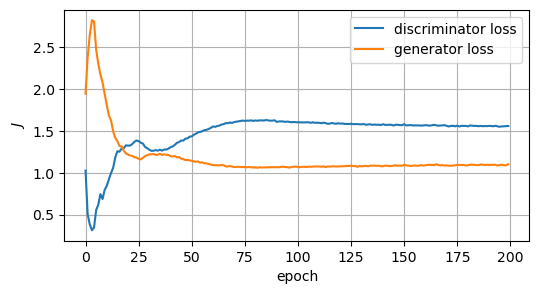

In [19]:
# plot out the losses
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(J_discriminator, label="discriminator loss")
ax.plot(J_generator, label="generator loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

We can examine what the model is generating as it is being trained (see [here](https://i.imgur.com/6PgtGOP.mp4) for a video), as well as at the end of the training.

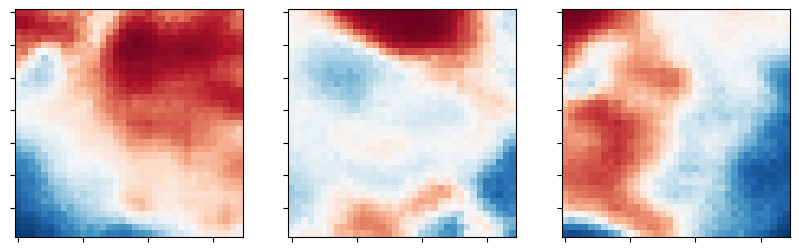

In [20]:
# make a prediction and show the outputs
with torch.no_grad():
    gen_SST = generator(torch.randn(3, noise_dim, 1, 1))

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

for i in range(3):
    axs[i].imshow(gen_SST[i, 0, :, :], cmap="RdBu_r", vmin=0, vmax=1, zorder=-10)
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

Are these "good"? It depends on what you mean by "good", but in this case I don't actually know, because I haven't explored the data all that much (it looks not unreasonable is all I can say). Some thought is probably needed to say whether the resulting synthetic data is realistic or not, but that's an exercise for you to consider.

> <span style="color:red">Q.</span> Have a look at and explore the provided dataset(s) to get an understanding on what is in fact in the data, and then gauge whether the synethetic data is "good" or not. For this you may want to go back to the original Kaggle data, which provides extra information that I didn't include here (that's deliberate).
>
> You may want to have a think about whether there are physical principles you may want to use to gauge whether the data is "good" or not. (Knowing what to look for is sometimes the main challenge, as it is in this case probably.)
>
> <span style="color:red">Q.</span> All the above with quantifying whether the distributions of the synthetic and real data is comparable could be deployed here with modification probably.
>
> If you are stuck on what to do, have a look at what people do for things like MNIST or FashionMNIST to get some ideas.
>
> <span style="color:red">Q.</span> You could train up classifiers (of whatever variety) on the real/synthetic data and deploy it for the synthetic/real data to see how comparable they are (or not) I suppose.

----------------
# More involved exercises with this notebook

> NOTE: The questions already rasied are already pretty involved and open-ended...

## 1) Use more of the Mercator eddy data

In the above I only did a vanilla GAN for one dataset. Consider including the other data provided also. The sample code below provides a suggestion on how you might merge the datsets.

Sometimes a problem is hard because we don't know what we are looking at, so I would actually recommend having a look at the raw data to see what is going on there first, which may help you gauge whether your trained GAN has any real skill (rather than numerical skill as measured by the loss function), experiencing mode-collapse, and others. Knowing what to look for is sometimes a good portion of the battle...

In [21]:
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "mercator_anticyclonic_eddy_SST.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/mercator_anticyclonic_eddy_SST.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df_1 = pd.read_csv(path, header=None)

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "mercator_cyclonic_eddy_SST.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/mercator_cyclonic_eddy_SST.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df_2 = pd.read_csv(path, header=None)

print(f"data has already been scaled to [0, 1]")
X = pd.concat((df_1, df_2), axis=1).values
print(f"  read data shape is (pixels, num_sample) = {X.shape}")

# reshape into something that PyTorch wants to see: (num_sample, channel, width, height)
X = X.T.reshape(-1, 35, 35, 1)
print(f"  reshaped to (num_sample, width, height, channel) = {X.shape}")

# Keras wants to see PyTorch (num_sample, width, height, channel) if you are using that

loading data remotely
loading data remotely
data has already been scaled to [0, 1]
  read data shape is (pixels, num_sample) = (1225, 2842)
  reshaped to (num_sample, width, height, channel) = (2842, 35, 35, 1)


## 2) Make a conditional DCGAN (cDCGAN)

Extend the vanilla DCGAN above to a conditional one. Refer to the referenced `PyTorch` on how you might include the label information in.

I would suggest starting first with the data labelled "with eddies" and "no eddies", before proceeding to data labelled with "anticyclonic", "cyclonic" and "no eddies".

## 3) `Keras` implementation of GANs

Using the `Keras` interface helps with packaging the code a bit better, so you could try implementing GANs with `Keras`.

As mentioned above, the GAN training strategy doesn't quite fit naturally under the `.fit()` framework, although we could use the `.train_on_batch()` to train the generator and discriminator accordingly (with the caveat we may need to batch the data ourselves, but that's fine). The `.fit()` and `.train_on_batch()` computes gradients and applies updates to the model in one go though, so we need a bit more control for GANs.

The thing I was not comfortable with (but I also didn't test it enough to say for sure) is the behaviour of freezing the relevant models at the associated training steps for GANs. The `Keras` tutorials (e.g. [here](https://keras.io/examples/generative/conditional_gan/), although this might be somewhat out of date with the new `Keras3`) suggest one way to do it is through `model.trainable = False`; this you might want to do with the discriminator at the generator training step. What is supposed to happen is that `discriminator.compile()` defines the discriminator and the model attributes are not changeable, then do `discriminator.traininable = False` and pass the resulting discriminator and the generator, call that the `GAN` and compile it, which deals supposedly deals with the taping accordingly. The things that I have doubts are:

* `discriminator.compile()` then `discriminator.traininable = False` should do nothing to the compiled model, but not convinced whether this is actually happening
* one thing I did try was to freeze and unfreeze during the training loop for the generator training step, which seems to do the "right" thing (but no strong evidence for this), which seems to be suggesting the above expected behaviour
* I played with the ordering (e.g. define the discriminator and generator, freeze the discriminator and compile the GAN, unfreeze the discriminator and compile the discriminator), but that also did funny things I didn't believe in (e.g. the generator was doing too well in the loss, suggesting the discriminator is in fact not frozen and being made worse during the generator update?)

It could be that I am simply doing it wrong (although various people have [kicked up a fuss](https://github.com/keras-team/keras/issues/4674)). It could be that the `PyTorch` backend behaves differently to the `TensorFlow` one. It could be that it is the model *layers* rather than the *model* itself that needs to be frozen for the steps. I didn't check comprehensively because I simply couldn't be bothered, because I judged that redoing everything through `PyTorch` would provide better return for investment in time because there I have faith `PyTorch` is doing what I think I am telling it to do (+ I prefer using `PyTorch` anyway...) 

I am sure you could get `Keras` to work for GANs, but I had no faith in my implementation and I couldn't be bothered figuring it out...thing I would go for is to check the weights during the epochs to see if they are being updated/frozen accordingly with the different combinations.

## 4) MNIST or other analogous data

Deploy GANs for other datasets, labelled or otherwise.